In [117]:
from torchaudio.transforms import AmplitudeToDB
import os

import torch

from config import SynthConfig, Config
from dataset.ai_synth_dataset import AiSynthDataset, create_data_loader, NSynthDataset
from model import helper
from model.model import SimpleSynthNetwork
from run_scripts.inference.inference_helper import inference_loop, process_batch_inference, nsynth_process_batch_inference
from synth.synth_architecture import SynthModular
import matplotlib.pyplot as plt

from librosa import amplitude_to_db

In [118]:
device = 'cuda:0'
preset = 'MODULAR'

## Create dataset
dataset_to_visualize = 'modular_synth50k'
split_to_visualize = 'val'
batch_size = 10
data_dir = os.path.join('data', dataset_to_visualize, split_to_visualize, '')

wav_files_dir = os.path.join(data_dir, 'wav_files', '')
params_csv_path = os.path.join(data_dir, 'params_dataset.pkl')

nsynth_dataset = AiSynthDataset(params_csv_path, wav_files_dir, device)
test_dataloader = create_data_loader(nsynth_dataset, batch_size, 0, shuffle=True)


## init
synth_cfg = SynthConfig()
cfg = Config()

synth_obj = SynthModular(synth_cfg=synth_cfg,
                         sample_rate=cfg.sample_rate,
                         signal_duration_sec=cfg.signal_duration_sec,
                         device=device,
                         preset=preset)

transform = helper.mel_spectrogram_transform(cfg.sample_rate).to(device)
normalizer = helper.Normalizer(synth_cfg.note_off_time, synth_cfg)

## Load model
model_ckpt_path1 = r'/home/almogelharar/almog/ai_synth/experiments/current/modular_synth_120e/ckpts/trained_synth_net.pt'
model_ckpt_path2 = r'/home/almogelharar/almog/ai_synth/experiments/current/modular_synth_40_40_40_min_param_decay01_cumsum_time/ckpts/synth_net_epoch70.pt'
model1 = SimpleSynthNetwork(preset, synth_cfg, cfg, device, backbone='resnet').to(device)
model2 = SimpleSynthNetwork(preset, synth_cfg, cfg, device, backbone='resnet').to(device)

/home/noyuzrad/ai_synth/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/noyuzrad/ai_synth/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [119]:
audio_batch = test_dataloader.__iter__().next()

In [120]:
model1.load_state_dict(torch.load(model_ckpt_path1, map_location=device))
model1.eval()
model2.load_state_dict(torch.load(model_ckpt_path2, map_location=device)['model_state_dict'])
model2.eval()

SimpleSynthNetwork(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [121]:
results1, metrics1 = nsynth_process_batch_inference(audio_batch[0], transform, model1, normalizer.denormalize, synth_obj, device, cfg, synth_cfg)


In [122]:
results2, metrics2 = nsynth_process_batch_inference(audio_batch[0], transform, model2, normalizer.denormalize, synth_obj, device, cfg, synth_cfg)


/home/noyuzrad/ai_synth/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [123]:
for metrics in [metrics1, metrics2]:
    for k, v in metrics.items():
        metrics[k] = v / 10

In [124]:
metrics2


defaultdict(float,
            {'lsd_value': 22.294907771258714,
             'pearson_stft': nan,
             'pearson_fft': nan,
             'mean_average_error': 2.4697296142578127,
             'mfcc_mae': 27.986773681640624,
             'spectral_convergence_value': 0.9945549011230469})

In [125]:
def plot_result(target_audio, pred_audio1, pred_audio2, target_spec, pred_spec1, pred_spec2):

    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    ax[0, 0].plot(target_audio)
    ax[0, 1].plot(pred_audio1)
    ax[0, 2].plot(pred_audio2)

    ax[1, 0].imshow(amplitude_to_db(target_spec), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))
    ax[1, 1].imshow(amplitude_to_db(pred_spec1), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))
    ax[1, 2].imshow(amplitude_to_db(pred_spec2), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))

    plt.show()

In [126]:
cfg

Config(sample_rate=16000, signal_duration_sec=4.0, mode=1, architecture='SPECTROGRAM_ONLY', spectrogram_loss_type='MULTI-SPECTRAL', freq_param_loss_type='MSE', model_frequency_output='SINGLE', transform='MEL_SPECTROGRAM', project_root=None, tensorboard_logdir=None, ckpts_dir=None, artifacts_dir=None, save_model_path=None, load_model_path=None, txt_path=None, numpy_path=None, num_epochs_to_save_model=10, regression_loss_factor=0.1, spectrogram_loss_factor=1e-05, freq_mse_loss_factor=0.001, freq_reinforce_loss_factor=100000.0, multi_spectral_loss_spec_type='BOTH', multi_spectral_loss_preset='mag_logmag', debug_mode=False, plot_spec=False, print_train_batch_stats=False, print_timings=False, print_synth_param_stats=False, print_accuracy_stats=False, print_per_accuracy_stats_multiple_epochs=True, log_spectrogram_mse_loss=False)

In [127]:
synth_cfg

SynthConfig(preset='MODULAR', semitones_max_offset=24, middle_c_freq=261.6255653005985, min_amp=0.05, max_amp=1, min_mod_index=0.01, max_mod_index=0.3, min_lfo_freq=0.5, max_lfo_freq=20, min_filter_freq=100, max_filter_freq=8000, min_resonance_val=0.01, max_resonance_val=10, min_amount_tremolo=0.05, max_amount_tremolo=1, fixed_note_off=True, note_off_time=3.0, margin=200, num_channels=3, num_layers=7)

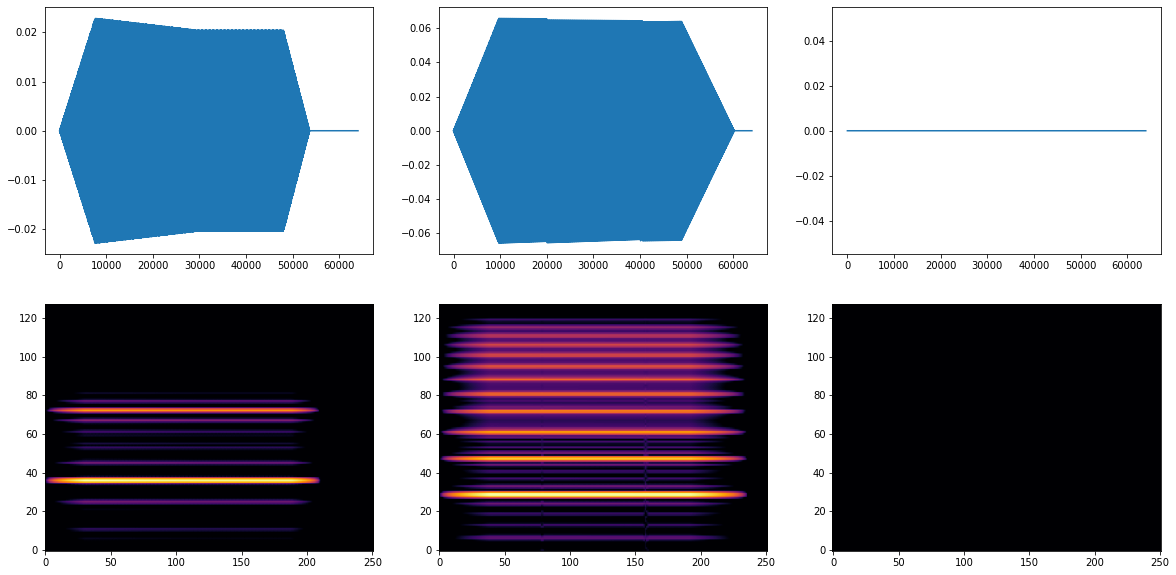

Sound 0 target

Sound 0 model1 prediction

Sound 0 model2 prediction

/home/noyuzrad/ai_synth/venv/lib/python3.8/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


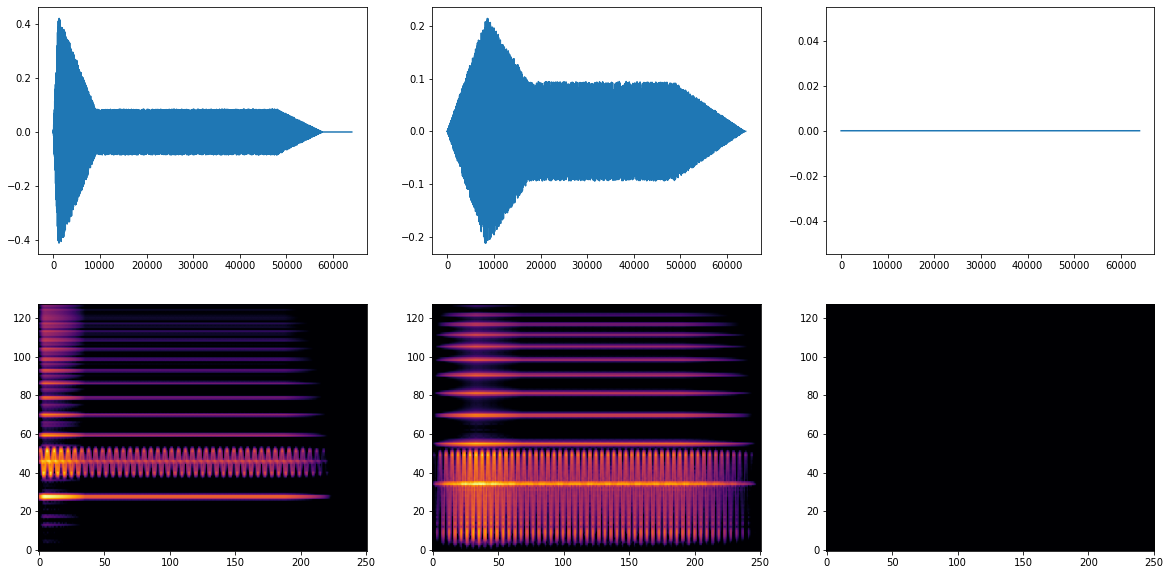

Sound 1 target

Sound 1 model1 prediction

Sound 1 model2 prediction

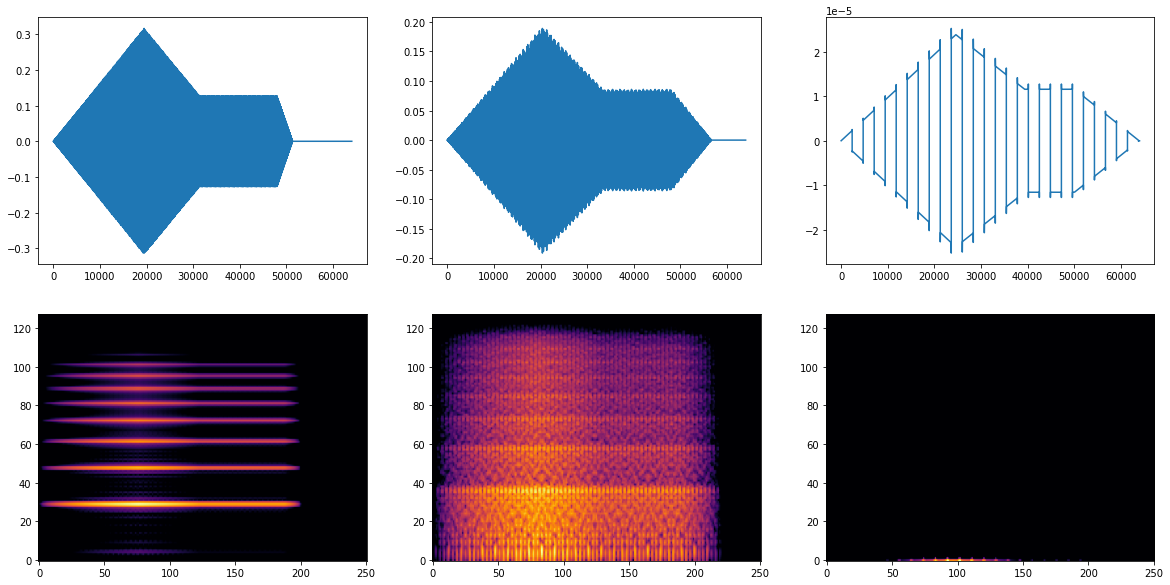

Sound 2 target

Sound 2 model1 prediction

Sound 2 model2 prediction

Exception ignored in: <function Wave_write.__del__ at 0x7fb7a09b1af0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/wave.py", line 327, in __del__
    self.close()
  File "/usr/lib/python3.8/wave.py", line 445, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.8/wave.py", line 465, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


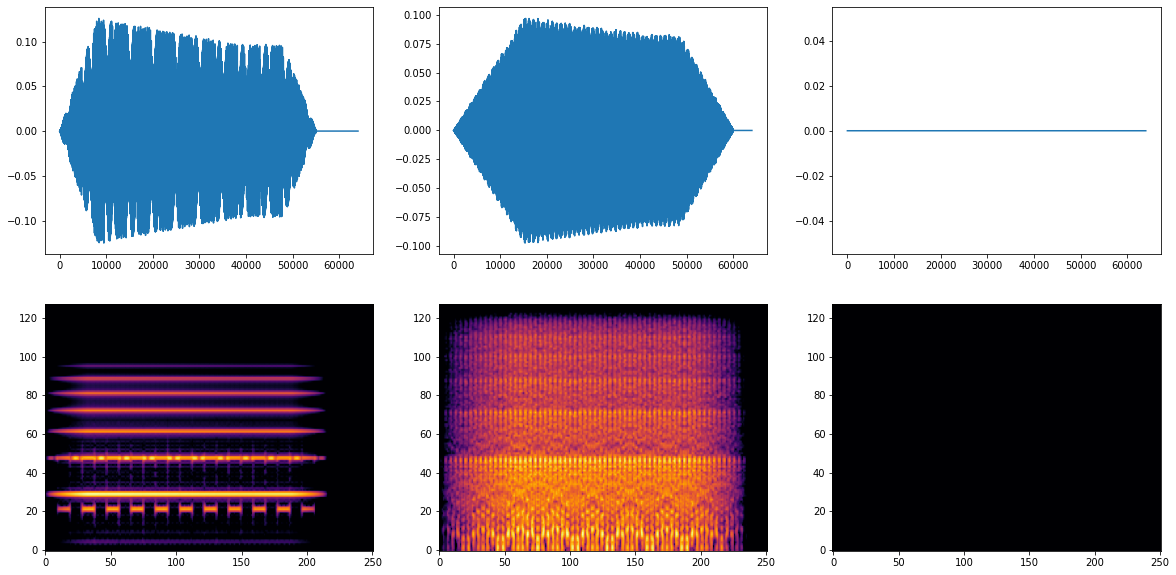

Sound 3 target

Sound 3 model1 prediction

Sound 3 model2 prediction

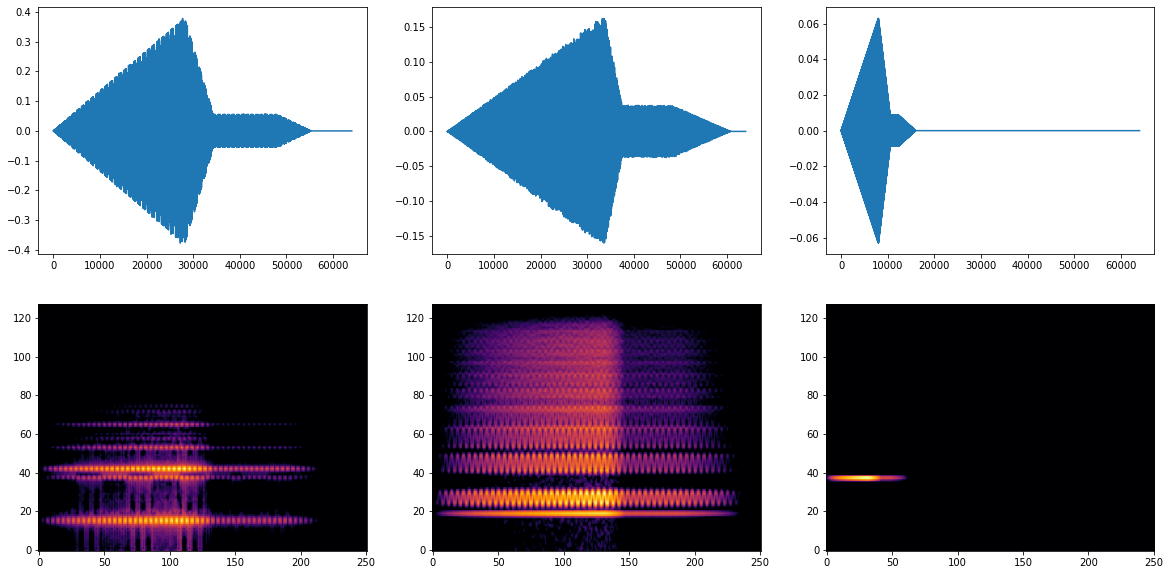

Sound 4 target

Sound 4 model1 prediction

Sound 4 model2 prediction

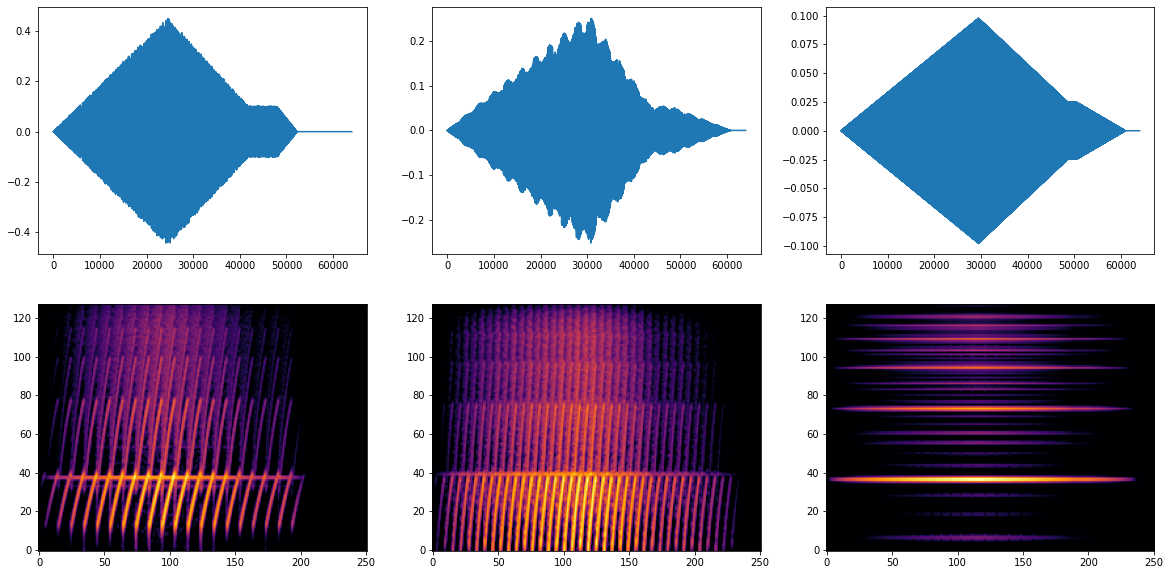

Sound 5 target

Sound 5 model1 prediction

Sound 5 model2 prediction

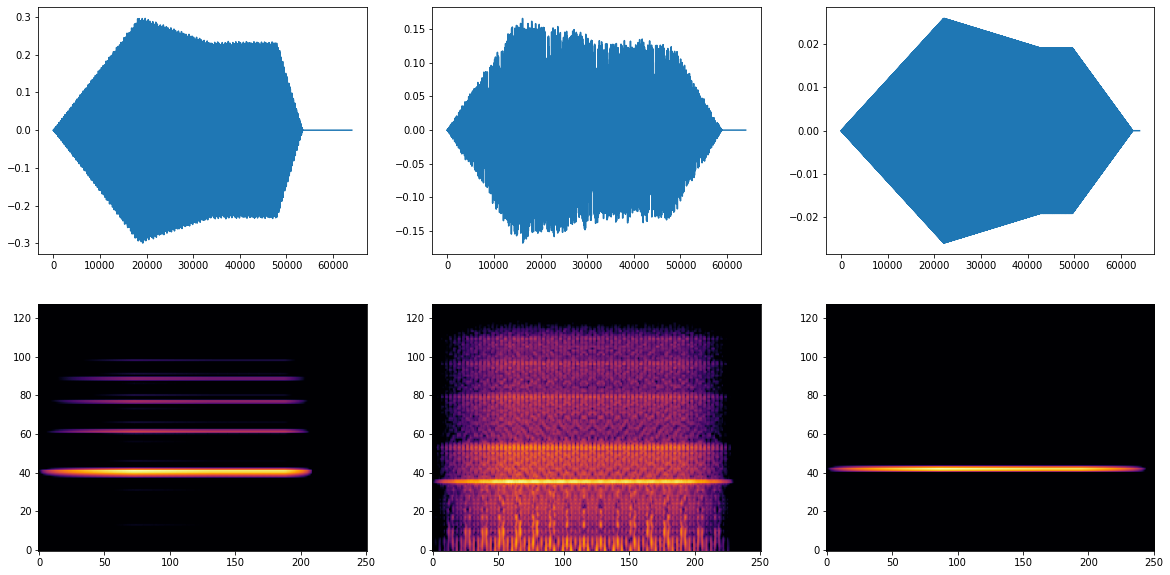

Sound 6 target

Sound 6 model1 prediction

Sound 6 model2 prediction

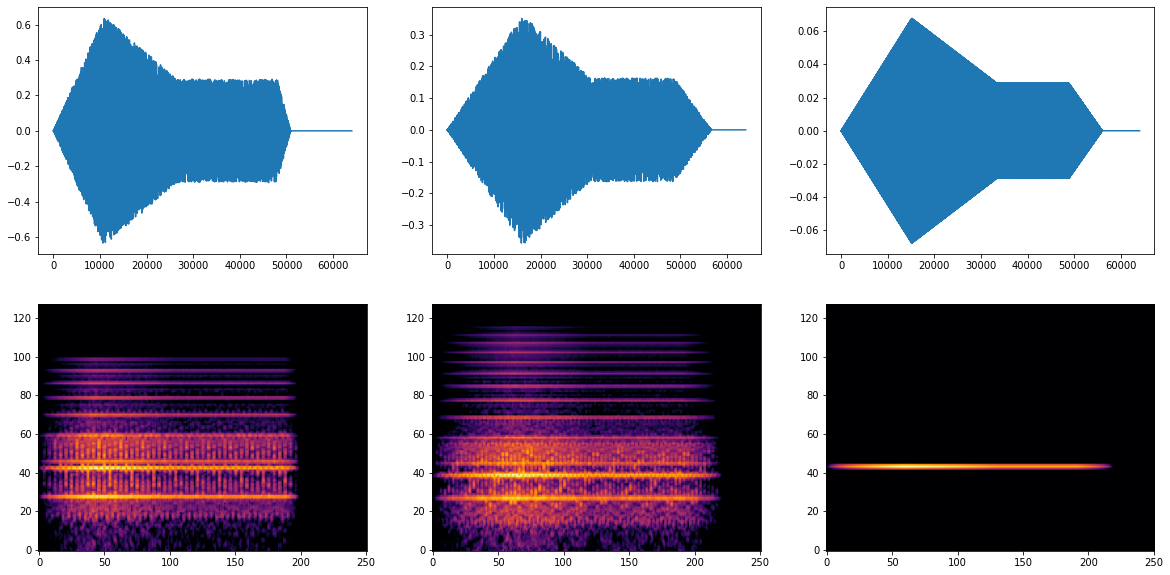

Sound 7 target

Sound 7 model1 prediction

Sound 7 model2 prediction

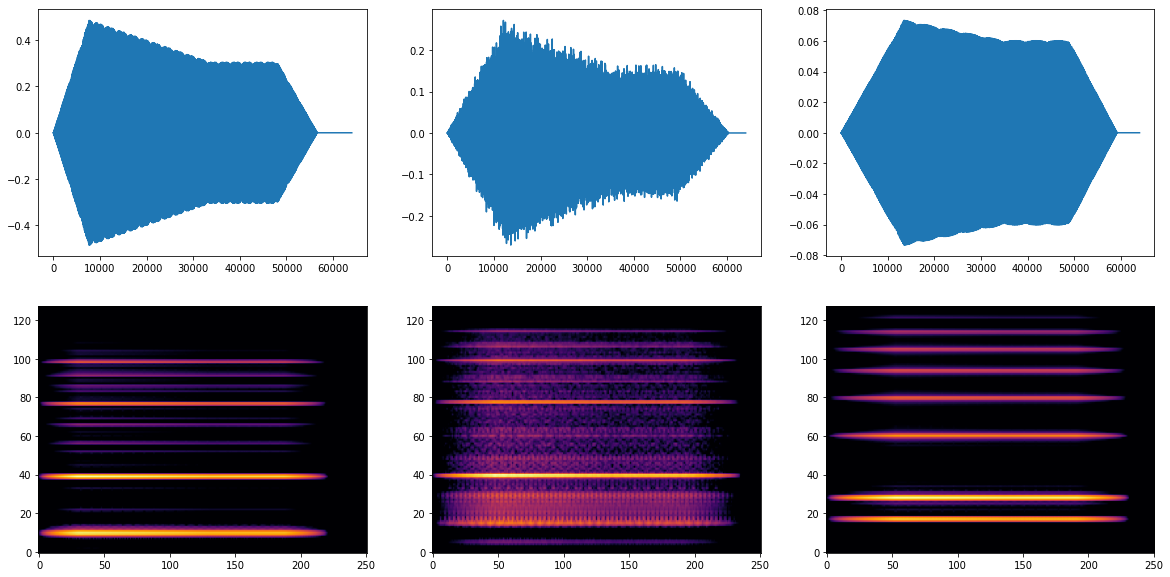

Sound 8 target

Sound 8 model1 prediction

Sound 8 model2 prediction

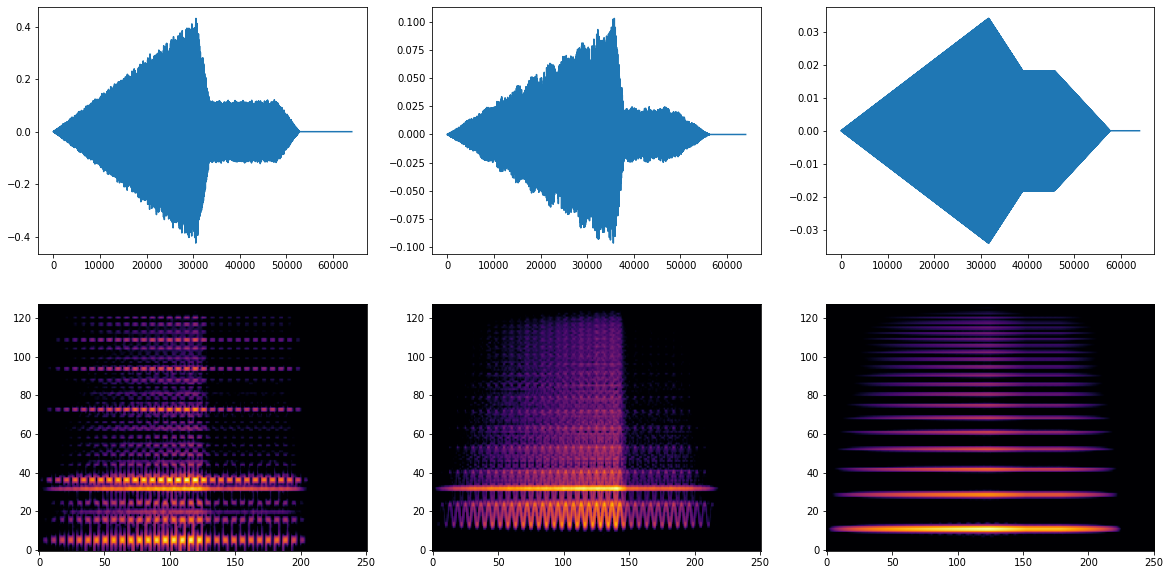

Sound 9 target

Sound 9 model1 prediction

Sound 9 model2 prediction

In [129]:
from IPython.display import display, Audio, Pretty


for i in range(batch_size):
    plot_result(results1['target_audio'][i], results1['predicted_audio'][i], results2['predicted_audio'][i],
                results1['target_spectrograms'][i], results1['predicted_spectrograms'][i], results2['predicted_spectrograms'][i])

    display(Pretty(f'Sound {i} target'))
    display(Audio(results1['target_audio'][i], rate=cfg.sample_rate, autoplay=False))

    display(Pretty(f'Sound {i} model1 prediction'))
    display(Audio(results1['predicted_audio'][i], rate=cfg.sample_rate, autoplay=False))

    display(Pretty(f'Sound {i} model2 prediction'))
    display(Audio(results2['predicted_audio'][i], rate=cfg.sample_rate, autoplay=False))